In [11]:
# Import Tensorflow & Pathlib librairies
import tensorflow as tf 
import pathlib 
import pandas as pd 
import numpy as np
import os
import io
import warnings
import keras
import regex as re
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D,Conv2D,Dropout,MaxPooling1D,Flatten
from unidecode import unidecode
import en_core_web_md
nlp = en_core_web_md.load()
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix

EDA

In [12]:
train = pd.read_csv('train.csv')

In [13]:
train.shape

(7613, 5)

In [14]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [15]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [16]:
train.shape

(7613, 5)

The missing values of the "keyword" column represent less than 1% of the dataset, it is kept.
We eliminate the "location" column to have too many missing values.

In [17]:
train = train[[col for col in train.columns if col != 'location']]
train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


We look at the unique values of the 'keyword' column.

In [18]:
train['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

We replace the "%20" with a space.

In [19]:
def replace20(x):
    
    try: 
        return x.replace('%20',' ')
    except AttributeError:
        return x

train['keyword'] = train['keyword'].apply(replace20)

train.head()

,id,keyword,text,target
0,1,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [20]:
train.groupby('keyword')['target'].mean().sort_values(ascending = False)

keyword
debris        1.000000
wreckage      1.000000
derailment    1.000000
outbreak      0.975000
oil spill     0.973684
                ...   
body bag      0.030303
blazing       0.029412
ruin          0.027027
body bags     0.024390
aftershock    0.000000
Name: target, Length: 221, dtype: float64

In [21]:
train["text"] = train["text"].apply(lambda x: str(x).lower())

In [22]:
train['is arobase']= train['text'].apply(lambda x:str(x).find('@') != -1).astype(int)

In [23]:
train['is arobase'].mean()

0.26783134112701956

In [24]:
print('If the tweet contains @, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is arobase')['target'].mean().loc[1],2))

print('If the tweet does not contain @, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is arobase')['target'].mean().loc[0],2))

If the tweet contains @, then the probability that it indicates a natural disaster is 0.33
If the tweet does not contain @, then the probability that it indicates a natural disaster is 0.47


In [25]:
train['is hashtag'] = train['text'].apply(lambda x:str(x).find('#') != -1).astype(int)

train['is hashtag'].mean()

0.2313148561670826

In [26]:
print('If the tweet contains #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[1],2))

print('If the tweet does not contain #, then the probability that it \
indicates a natural disaster is' , round(train.groupby('is hashtag')['target'].mean().loc[0],2))

If the tweet contains #, then the probability that it indicates a natural disaster is 0.5
If the tweet does not contain #, then the probability that it indicates a natural disaster is 0.41


Pre-processing

In [27]:
train['text'] = train['text'].apply(unidecode)

We create a function that cleans the texts.

In [28]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
stops = set(stopwords.words('english'))
import spacy
sp = spacy.load('en_core_web_sm')

spacy_stopwords = sp.Defaults.stop_words

stops = stops.union(spacy_stopwords)

stops = stops.union({' ','.',',','',"i'm",'u','rt','http','like','//t','girl','girls',"'",'"','mkr'})

def remove_stop_words(words):

   return [word.lower() for word in words if word.lower() not in stops]  

import textcleaner as tc


def clean_text(text): 
    
  token_text = nlp(text)
    
  text = [element.lemma_.lower() for element in token_text]  

  clean_text = remove_stop_words(text)  
    
  text = " ".join(clean_text).strip().lower()  
  
  text = re.sub(r'[0-9]+','',text).strip()
  text = re.sub(r'[@]+','@',text).strip()
  text = re.sub(r'@','@ ', text).strip()  
  text = re.sub(r'[#]+','#',text).strip()
  text = re.sub(r'#','# ', text).strip() 
#  text = re.sub(r'\x[0-9]+','',text).strip()  
  text = re.sub(r'rt[\s]+','', text).strip()
  text = re.sub(r"[,.\"!$%^&*(){}?/;`~:<>_+=-]", "", text).strip()
  text = re.sub(r'http[A-Za-z0-9]+','', text).strip()
  text = re.sub(r'bbc','',text) .strip() 
  emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
  text = emoji.sub(r'', text).strip()   
  text = re.sub(r"i'm", "i am", text).strip()
  text = re.sub(r"he's", "he is", text).strip()
  text = re.sub(r"she's", "she is", text).strip()
  text = re.sub(r"that's", "that is", text).strip()        
  text = re.sub(r"what's", "what is", text).strip()
  text = re.sub(r"where's", "where is", text).strip() 
  text = re.sub(r"\'ll", " will", text).strip()  
  text = re.sub(r"\'ve", " have", text).strip()  
  text = re.sub(r"\'re", " are", text).strip()
  text = re.sub(r"\'d", " would", text).strip()
  text = re.sub(r"\'ve", " have", text).strip()
  text = re.sub(r"won't", "will not", text).strip()
  text = re.sub(r"don't", "do not", text).strip()
  text = re.sub(r"did't", "did not", text).strip()
  text = re.sub(r"can't", "can not", text).strip()
  text = re.sub(r"it's", "it is", text).strip()
  text = re.sub(r"couldn't", "could not", text).strip()
  text = re.sub(r"have't", "have not", text).strip()
  text = re.sub(r'[\s]+',' ',text)
    
  text = text.lower()   
    
#  text = remove_stop_words2(text).strip()

#  text = " ".join(text).strip()
 
  return text.split(" ")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matthieu.marechal\AppData\Roaming\nltk_data..
[nltk_data]     .
[nltk_data]   Package punkt is already up-to-date!


In [29]:
train['token_text'] = train['text'].apply(clean_text)

train['text_cleaned'] = train['token_text'].apply(lambda x : " ".join(x))
train

,id,keyword,text,target,is arobase,is hashtag,token_text,text_cleaned
0,1,NaN,our deeds are the reason of this #earthquake m...,1,0,1,"[deed, reason, #, earthquake, allah, forgive]",deed reason # earthquake allah forgive
1,4,NaN,forest fire near la ronge sask. canada,1,0,0,"[forest, fire, near, la, ronge, sask, canada]",forest fire near la ronge sask canada
2,5,NaN,all residents asked to 'shelter in place' are ...,1,0,0,"[resident, ask, shelter, place, notify, office...",resident ask shelter place notify officer evac...
3,6,NaN,"13,000 people receive #wildfires evacuation or...",1,0,1,"[people, receive, #, wildfire, evacuation, ord...",people receive # wildfire evacuation order cal...
4,7,NaN,just got sent this photo from ruby #alaska as ...,1,0,1,"[got, send, photo, ruby, #, alaska, smoke, #, ...",got send photo ruby # alaska smoke # wildfire ...
...,...,...,...,...,...,...,...,...
7608,10869,NaN,two giant cranes holding a bridge collapse int...,1,0,0,"[giant, crane, hold, bridge, collapse, nearby,...",giant crane hold bridge collapse nearby home
7609,10870,NaN,@aria_ahrary @thetawniest the out of control w...,1,1,0,"[@, ariaahrary, @, thetawni, control, wild, fi...",@ ariaahrary @ thetawni control wild fire cali...
7610,10871,NaN,m1.94 [01:04 utc]?5km s of volcano hawaii. htt...,1,0,0,"[m, [, utc], km, volcano, hawaii]",m [ utc] km volcano hawaii
7611,10872,NaN,police investigating after an e-bike collided ...,1,0,0,"[police, investigate, e, bike, collide, car, l...",police investigate e bike collide car little p...


In [30]:
def clean_keyword(x):
    
    try:
        clean_token = clean_text(x)
        return " ".join(clean_token)
    except ValueError:
        return ""

train['keyword_cleaned'] = train['keyword'].apply(clean_keyword)

In [31]:
train.iloc[:,[1,-1]].sample(16)

,keyword,keyword_cleaned
4257,heat wave,heat wave
1732,collided,collide
6425,suicide bomber,suicide bomber
2483,desolate,desolate
6864,trauma,trauma
6293,stretcher,stretcher
2031,danger,danger
1655,collapsed,collapse
874,blood,blood
6368,suicide bomb,suicide bomb


In [32]:
train['keyword_text_cleaned'] = train.keyword_cleaned + ' ' + train.text_cleaned

We look at the word clouds associated with each value of the target.

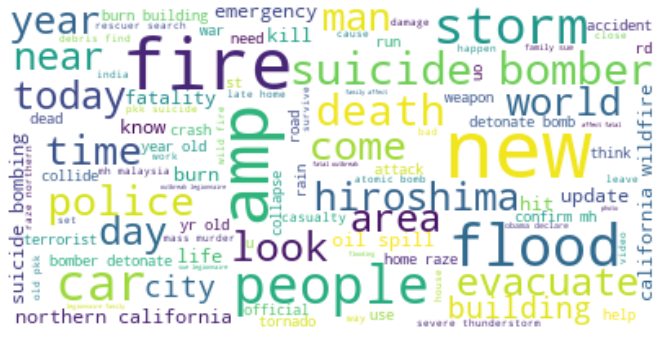

In [33]:
import matplotlib.pyplot as plt

text = " ".join(review for review in train[train['target'] == 1]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

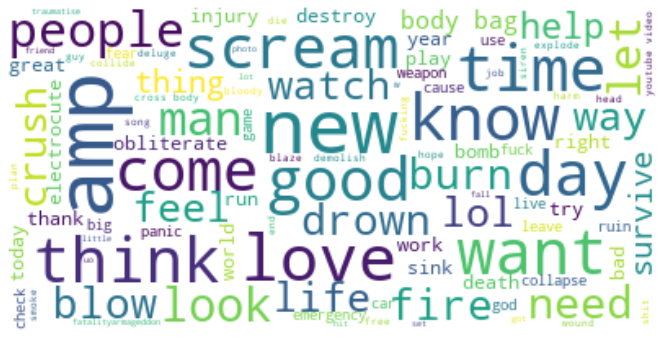

In [34]:
text = " ".join(review for review in train[train['target'] == 0]['token_text'].apply(lambda x : " ".join(x)))
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
fig = plt.figure(figsize = (20, 6)) 
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [35]:
list_words_df3_label1 = []

for words in train[train['target'] == 1]['token_text'].tolist():
    list_words_df3_label1 += words

list_words_df3_label0 = []

for words in train[train['target'] == 0]['token_text'].tolist():
    list_words_df3_label0 += words

In [36]:
pd.DataFrame({'words':list_words_df3_label1}).value_counts().sort_values(ascending = False)[:10]

words     
#             1679
@              885
fire           268
kill           156
news           141
disaster       121
california     115
bomb           113
year           112
crash          112
dtype: int64

In [37]:
pd.DataFrame({'words':list_words_df3_label0}).value_counts().sort_values(ascending = False)[:10]

words
@        1827
#        1670
amp       193
new       172
good      120
body      119
love      117
come      108
time      106
video     103
dtype: int64

Train models

In [38]:
train['target'].mean()

0.4296597924602653

This is an unbalanced dataframe.

Model 1: with @ and #.

In [86]:
df = train.copy()

In [87]:
import numpy as np
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer1.fit_on_texts(df.keyword_text_cleaned)
df["text_encoded"] = tokenizer1.texts_to_sequences(df.text_cleaned)
df["len_text"] = df["text_encoded"].apply(lambda x: len(x))

In [88]:
df1 = df[df["len_text"]!=0]

text_pad1 = tf.keras.preprocessing.sequence.pad_sequences(df1.text_encoded, padding="post")

y = df1['target'].values

In [89]:
keyword_pad1 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer1.texts_to_sequences(df1.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad1 = np.concatenate([keyword_pad1,text_pad1],axis = 1)

In [90]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad1,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [91]:
X_train.shape

(4529, 17)

In [92]:
vocab_size = tokenizer1.num_words
model1 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],\
                                         name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = 'l2' # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [93]:
model1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 conv1d_6 (Conv1D)           (None, 17, 14)            5390      
                                                                 
 global_average_pooling1d_5   (None, 14)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_14 (Dense)            (None, 50)                750       
                                                                 
 dense_15 (Dense)            (None, 16)                816       
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                      

In [105]:
optimizer= keras.optimizers.Adam()

model1.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model1.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=5, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/5
50/50 [==============================] - 2s 11ms/step - loss: 0.1410 - mean_absolute_error: 0.2910 - val_loss: 0.1562 - val_mean_absolute_error: 0.3004
Epoch 2/5
50/50 [==============================] - 0s 8ms/step - loss: 0.1421 - mean_absolute_error: 0.2855 - val_loss: 0.1558 - val_mean_absolute_error: 0.3039
Epoch 3/5
50/50 [==============================] - 0s 8ms/step - loss: 0.1270 - mean_absolute_error: 0.2629 - val_loss: 0.1531 - val_mean_absolute_error: 0.2816
Epoch 4/5
50/50 [==============================] - 0s 8ms/step - loss: 0.1263 - mean_absolute_error: 0.2528 - val_loss: 0.1509 - val_mean_absolute_error: 0.2802
Epoch 5/5
50/50 [==============================] - 0s 9ms/step - loss: 0.1164 - mean_absolute_error: 0.2384 - val_loss: 0.1530 - val_mean_absolute_error: 0.2769


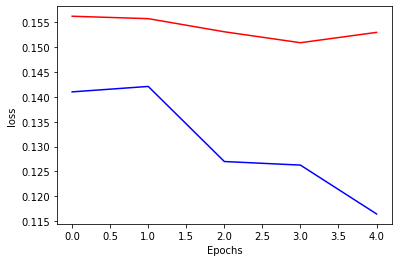

In [106]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [108]:
y_train_pred = model1.predict(X_train)
y_test_pred = model1.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [109]:
np.array(y_train).mean()

0.4318834179730625

In [110]:
np.array(y_val).mean()

0.43178807947019865

In [111]:
print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' , f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8661956281739899
accuracy score test : 0.7933774834437086
f1 score train : 0.8370967741935484
f1 score test : 0.7475728155339806


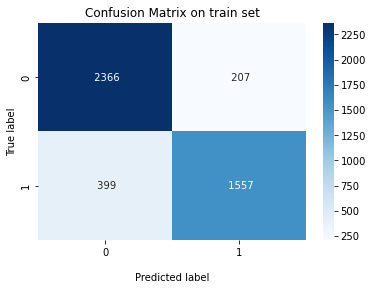

In [112]:
import seaborn as sns
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

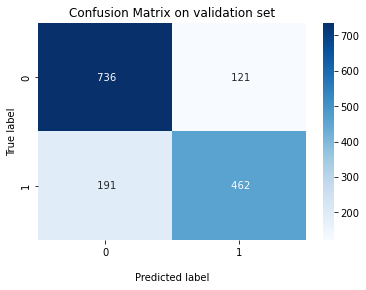

In [113]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on validation set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

In [114]:
df1['pred prob target'] = model1.predict(text_pad1)
df1['pred target'] = df1['pred prob target'].apply(lambda x : x>0.5)

236/236 [==============================] - 1s 2ms/step


In [115]:
size = ((df1.target == 1)&(df1['pred target'] == 0)).sum()

idx = np.random.randint(size)

df1[(df1.target == 1)&(df1['pred target'] == 0)].iloc[idx]['text']

'this is set to become a huge one month wonder. (and then pornhub will be inundated....) http://t.co/gghfx8pzmh'

Model2: same model than model1 but we eliminate @ and #.

In [127]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer2 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer2.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer2.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df2 = df_bis[df_bis["len_text"]!=0]

text_pad2 = tf.keras.preprocessing.sequence.pad_sequences(df2.text_encoded, padding="post")

y = df2['target'].values

keyword_pad2 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer2.texts_to_sequences(df2.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad2 = np.concatenate([keyword_pad2,text_pad2],axis = 1)

In [128]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad2,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [129]:
vocab_size = tokenizer2.num_words
model2 = keras.Sequential([
                  # Couche d'Input Word Embedding  
                  keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"),
                  Conv1D(
filters = 14, # the number of neurons on the convolutional layer
kernel_size = (3), # the number of elements of the input the neuron will analyse at once
strides = 1, # how should the filters move along the conv dimension on the input
padding = "same", # "valid" means no padding, "same" means output shape = input shape
activation = "relu", # the activation function
kernel_regularizer = None # regularization on the neuron's parameters
),
                      keras.layers.GlobalAveragePooling1D(),
#                  keras.layers.Dense(50, activation='relu'),
                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
#                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  keras.layers.Dense(1, activation="sigmoid")
])

In [130]:
optimizer= keras.optimizers.Adam()

model2.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

# Entrainement du modèle 
history = model2.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=6, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/6
50/50 [==============================] - 1s 13ms/step - loss: 0.2395 - mean_absolute_error: 0.4846 - val_loss: 0.2231 - val_mean_absolute_error: 0.4644
Epoch 2/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1868 - mean_absolute_error: 0.4085 - val_loss: 0.1590 - val_mean_absolute_error: 0.3450
Epoch 3/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1385 - mean_absolute_error: 0.2995 - val_loss: 0.1516 - val_mean_absolute_error: 0.3061
Epoch 4/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1268 - mean_absolute_error: 0.2650 - val_loss: 0.1487 - val_mean_absolute_error: 0.2807
Epoch 5/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1197 - mean_absolute_error: 0.2520 - val_loss: 0.1489 - val_mean_absolute_error: 0.2761
Epoch 6/6
50/50 [==============================] - 0s 8ms/step - loss: 0.1153 - mean_absolute_error: 0.2400 - val_loss: 0.1497 - val_mean_absolute_error: 0.2684


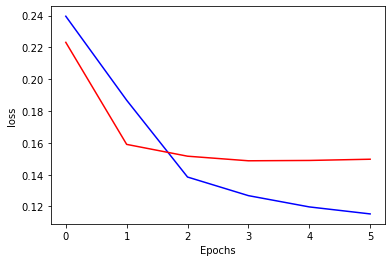

In [131]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [132]:
y_train_pred = model2.predict(X_train)
y_test_pred = model2.predict(X_test)

48/48 [==============================] - 0s 2ms/step


In [133]:
print('accuracy score train :', accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :', accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train :' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test :' ,  f1_score(y_test,y_test_pred>0.5))

accuracy score train : 0.8677412232280857
accuracy score test : 0.8013245033112583
f1 score train : 0.8367402562005996
f1 score test : 0.7532894736842105


The results are good. We now test a new model where we use Long short-term memory. 

model3

In [223]:
tokenizer3 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer3.fit_on_texts(df.keyword_text_cleaned)

df3 = df.copy()

tweet_pads3 = tokenizer3.texts_to_sequences(df3.text_cleaned)

In [224]:
tweet_pads3 = tf.keras.preprocessing.sequence.pad_sequences(tweet_pads3, padding="post")

In [225]:
keyword_pads3 = tokenizer3.texts_to_sequences(df3.keyword_cleaned.tolist())

In [226]:
keyword_pads3 = tf.keras.preprocessing.sequence.pad_sequences(keyword_pads3, padding="post")

In [227]:
keyword_tweet_pads3 = np.concatenate([keyword_pads3,tweet_pads3],axis = 1)

In [228]:
y = df3['target']

In [229]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_tweet_pads3,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [230]:
X_test.shape

(1523, 17)

In [231]:
model3 = keras.models.Sequential()

model3.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model3.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model3.add(keras.layers.Dropout(0.2))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model3.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [232]:
model3.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional_3 (Bidirectio  (None, 30)               17280     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 30)                0         
                                                                 
 dense_32 (Dense)            (None, 64)                1984      
                                                                 
 dense_33 (Dense)            (None, 64)                4160      
                                                                 
 dense_34 (Dense)            (None, 32)                2080      
                                                     

In [233]:
optimizer= keras.optimizers.Adam()

model3.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [234]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=8, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/8
50/50 [==============================] - 7s 40ms/step - loss: 0.3499 - mean_absolute_error: 0.4828 - val_loss: 0.2978 - val_mean_absolute_error: 0.4575
Epoch 2/8
50/50 [==============================] - 1s 17ms/step - loss: 0.2374 - mean_absolute_error: 0.3605 - val_loss: 0.2094 - val_mean_absolute_error: 0.3004
Epoch 3/8
50/50 [==============================] - 1s 18ms/step - loss: 0.1886 - mean_absolute_error: 0.2950 - val_loss: 0.1910 - val_mean_absolute_error: 0.2889
Epoch 4/8
50/50 [==============================] - 1s 19ms/step - loss: 0.1558 - mean_absolute_error: 0.2572 - val_loss: 0.1816 - val_mean_absolute_error: 0.2866
Epoch 5/8
50/50 [==============================] - 1s 18ms/step - loss: 0.1411 - mean_absolute_error: 0.2418 - val_loss: 0.1862 - val_mean_absolute_error: 0.2843
Epoch 6/8
50/50 [==============================] - 1s 18ms/step - loss: 0.1337 - mean_absolute_error: 0.2395 - val_loss: 0.1827 - val_mean_absolute_error: 0.2896
Epoch 7/8
50/50 [===========

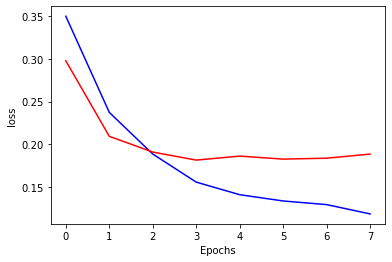

In [235]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [236]:
y_train_pred = model3.predict(X_train)
y_test_pred = model3.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 4ms/step
accuracy score train : 0.8887672432669148
accuracy score test : 0.7872619829284307
f1 score train :  0.8645333333333333
f1 score test :  0.7387096774193547


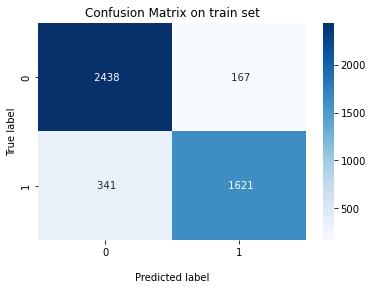

In [237]:
ax = sns.heatmap(confusion_matrix(y_train, y_train_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

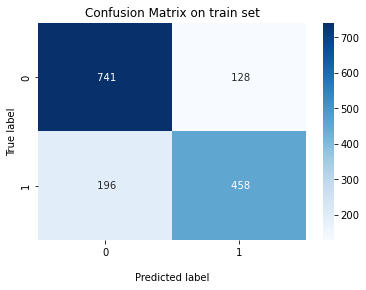

In [238]:
ax = sns.heatmap(confusion_matrix(y_test, y_test_pred>0.5), annot=True, 
            fmt=' ', cmap='Blues')

ax.set_title('Confusion Matrix on train set');
ax.set_xlabel('\nPredicted label')
ax.set_ylabel('True label');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels([0,1])
ax.yaxis.set_ticklabels([0,1])

## Display the visualization of the Confusion Matrix.
plt.show()

Results are not better than model2. We now removing @ and #.

In [148]:
df_bis = df.copy()

df_bis['text'] = df_bis['text'].apply(lambda x : re.sub('[@#]','',x))

tokenizer4 = tf.keras.preprocessing.text.Tokenizer(num_words=1000) # instanciate the tokenizer
tokenizer4.fit_on_texts(df_bis.keyword_text_cleaned)
df_bis["text_encoded"] = tokenizer4.texts_to_sequences(df_bis.text_cleaned)
df_bis["len_text"] = df_bis["text_encoded"].apply(lambda x: len(x))

df4 = df_bis[df_bis["len_text"]!=0]

text_pad4 = tf.keras.preprocessing.sequence.pad_sequences(df4.text_encoded, padding="post")

y = df4['target'].values

keyword_pad4 = tf.keras.preprocessing.sequence.pad_sequences(tokenizer4.texts_to_sequences(df4.keyword_cleaned),\
                                              padding = "post")

keyword_text_pad4 = np.concatenate([keyword_pad4,text_pad4],axis = 1)

In [149]:
X_train,X_testi,y_train,y_testi = train_test_split(keyword_text_pad4,y,test_size = 0.4,stratify = y)

X_test,X_val,y_test,y_val = train_test_split(X_testi,y_testi,test_size = 0.5, stratify = y_testi)

In [150]:
model4 = keras.models.Sequential()

model4.add(keras.layers.Embedding(vocab_size+1, 128, input_shape=[X_train.shape[1],],name="embedding"))

model4.add(keras.layers.Bidirectional(keras.layers.LSTM(15,dropout=0.2)))# LSTM layer

model4.add(keras.layers.Dropout(0.2))

model4.add(keras.layers.Dense(64, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu', input_shape=(X_train.shape[1],)))

model4.add(keras.layers.Dense(32, kernel_regularizer=keras.regularizers.l2(0.001), activation='relu'))

model4.add(keras.layers.Dense(1, activation='sigmoid'))
#reg_model.name = 'L2 Regularization model'

In [151]:
model4.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 17, 128)           128128    
                                                                 
 bidirectional_1 (Bidirectio  (None, 30)               17280     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30)                0         
                                                                 
 dense_25 (Dense)            (None, 64)                1984      
                                                                 
 dense_26 (Dense)            (None, 32)                2080      
                                                                 
 dense_27 (Dense)            (None, 1)                 33        
                                                      

In [152]:
optimizer= keras.optimizers.Adam()

model4.compile(optimizer=optimizer,
              loss=keras.losses.MeanSquaredError(),
              metrics=[keras.metrics.MeanAbsoluteError()])

In [153]:
# Entrainement du modèle 
history = model3.fit(x=X_train,y=y_train,batch_size = 64, 
                    epochs=15, 
                    validation_data=(X_val,y_val),steps_per_epoch = 50)

Epoch 1/15
50/50 [==============================] - 8s 66ms/step - loss: 0.1390 - mean_absolute_error: 0.2504 - val_loss: 0.1300 - val_mean_absolute_error: 0.2502
Epoch 2/15
50/50 [==============================] - 1s 20ms/step - loss: 0.1251 - mean_absolute_error: 0.2359 - val_loss: 0.1340 - val_mean_absolute_error: 0.2338
Epoch 3/15
50/50 [==============================] - 1s 21ms/step - loss: 0.1311 - mean_absolute_error: 0.2431 - val_loss: 0.1369 - val_mean_absolute_error: 0.2434
Epoch 4/15
50/50 [==============================] - 1s 23ms/step - loss: 0.1152 - mean_absolute_error: 0.2151 - val_loss: 0.1426 - val_mean_absolute_error: 0.2502
Epoch 5/15
50/50 [==============================] - 1s 22ms/step - loss: 0.1090 - mean_absolute_error: 0.2025 - val_loss: 0.1474 - val_mean_absolute_error: 0.2426
Epoch 6/15
50/50 [==============================] - 1s 20ms/step - loss: 0.1066 - mean_absolute_error: 0.2036 - val_loss: 0.1490 - val_mean_absolute_error: 0.2315
Epoch 7/15
50/50 [====

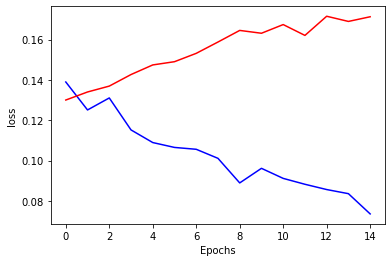

In [154]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

In [155]:
y_train_pred = model4.predict(X_train)
y_test_pred = model4.predict(X_test)

print('accuracy score train :' , accuracy_score(y_train,y_train_pred>0.5))
print('accuracy score test :' , accuracy_score(y_test,y_test_pred>0.5))
print('f1 score train : ' , f1_score(y_train,y_train_pred>0.5))
print('f1 score test : ' ,  f1_score(y_test,y_test_pred>0.5))

48/48 [==============================] - 0s 5ms/step
accuracy score train : 0.5683373813203798
accuracy score test : 0.5675496688741721
f1 score train :  0.001021972406745018
f1 score test :  0.0


These results are very bad. We finally use model2 on sample submission.

In [239]:
sample = pd.read_csv('sample_submission.csv',index_col = 0)

In [240]:
test = pd.read_csv('test.csv')

In [241]:
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [242]:
test['keyword'] = test['keyword'].apply(replace20)

In [243]:
test['text_cleaned']=test['text'].apply(clean_text).apply(lambda x : " ".join(x))
test.head()

,id,keyword,location,text,text_cleaned
0,0,NaN,NaN,Just happened a terrible car crash,happen terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",hear # earthquake different city stay safe
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",forest fire spot pond geese flee street save
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,apocalypse lighting # spokane # wildfire
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,typhoon soudelor kill china taiwan


In [244]:
test['keyword_cleaned'] = test['keyword'].apply(clean_keyword)
test.sample(15)

,id,keyword,location,text,text_cleaned,keyword_cleaned
2449,8185,rescuers,Florida,When Rescuers Found Him He ... http://t.co/sTD...,rescuer find,rescuer
1976,6666,landslide,NaN,WATCH: Likely landslide victims denied assista...,watch likely landslide victim deny assistance,landslide
1810,6122,hellfire,???? ???????,#Allah describes piling up #wealth thinking it...,# allah describe pile # wealth thinking # fore...,hellfire
679,2202,catastrophic,www.facebook.com/Randirobics,Society will collapse by 2040 due to catastrop...,society collapse catastrophic food shortage study,catastrophic
1505,5012,eyewitness,California,Read an eyewitness account from #Hiroshima on ...,read eyewitness account # hiroshima aug mankin...,eyewitness
2377,7947,rainstorm,"Calgary, Alberta",@WerdEmUp It's already been messed up thanks t...,@ werdemup mess thank early rainstorm need mai...,rainstorm
2016,6782,lightning,"Philadelphia, PA",Two Films From Villanova University Students S...,films villanova university student selected st...,lightning
92,311,annihilated,NaN,@_drodrolagi #handplacementgoals \nBro we anni...,@ drodrolagi # handplacementgoal bro annihilat...,annihilate
196,632,arsonist,"San Luis Obispo, California",Suspected serial arsonist arrested in NorCal h...,suspect serial arsonist arrest norcal,arsonist
917,3020,death,New York,Microsoft Xbox 360 console RRoD red ring of de...,microsoft xbox console rrod red ring death par...,death


In [245]:
test['text_cleaned'] = test['text_cleaned'].apply(lambda x : re.sub(r'[@#]','',x))

In [247]:
test.loc[898,'text_cleaned']

'hope ross amp val dead  emmerdale  summerfate'

In [248]:
test['keyword_cleaned'].unique()

array(['', 'ablaze', 'accident', 'aftershock', 'airplane accident',
       'ambulance', 'annihilate', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'avalanche',
       'battle', 'bioterror', 'bioterrorism', 'blaze', 'bleeding', 'blow',
       'blight', 'blizzard', 'blood', 'bloody', 'body bag',
       'body bagging', 'bomb', 'bombing', 'bridge collapse',
       'building burn', 'building fire', 'burn', 'burning',
       'burn building', 'bush fire', 'casualty', 'catastrophe',
       'catastrophic', 'chemical emergency', 'cliff fall', 'collapse',
       'collide', 'collision', 'crash', 'crush', 'curfew', 'cyclone',
       'damage', 'danger', 'dead', 'death', 'debris', 'deluge',
       'demolish', 'demolition', 'derail', 'derailment', 'desolate',
       'desolation', 'destroy', 'destruction', 'detonate', 'detonation',
       'devastate', 'devastation', 'disaster', 'displace', 'drought',
       'drown', 'dust storm', 'earthquake', 'electrocute',

In [250]:
text_encoded = tokenizer2.texts_to_sequences(test.text_cleaned)
text_pad = tf.keras.preprocessing.sequence.pad_sequences(text_encoded, padding="post")
text_pad[:5,:]

array([[276,  79,  11,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [218,  99, 927, 204, 402,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 78,   1, 527, 421, 155,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [207,  76,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [ 95, 514,  24, 394, 932,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])

In [251]:
text_pad.shape

(3263, 15)

In [252]:
keywords_encoded = tokenizer2.texts_to_sequences(test.keyword_cleaned)
keyword_pad = tf.keras.preprocessing.sequence.pad_sequences(keywords_encoded, padding="post")
keyword_pad.shape

(3263, 2)

In [253]:
keyword_text_pad = np.concatenate([keyword_pad,text_pad],axis = 1)
keyword_text_pad.shape

(3263, 17)

In [254]:
sample['target']=(model2.predict(keyword_text_pad)>0.5).astype(int)

102/102 [==============================] - 0s 2ms/step


In [255]:
sample.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [256]:
predict1 = sample[sample.target == 1].index
predict0 = sample[sample.target == 0].index

In [257]:
idx = np.random.randint(len(predict1))

test.loc[predict1].iloc[idx]['text']

'@caseyliss def - and don\x89Ûªt even fathom when there is bad weather / flooding ??\n\n#byebyeroad'

In [258]:
idx = np.random.randint(len(predict0))

test.loc[predict0].iloc[idx]['text']

'Holy hell the bathroom on car 649 smells like is exploded... @Metrolink'

In [259]:
sample.to_csv('sample_submission.csv')